Todo:
 1. remove noisy samples: one option - remove rows with num of nan > trash
 2. feature selection (annova, pca) 
 3. check for cat boost 
 4. check SMOTETomek and undersample & SMOTENC
 
Must:
 1. XGBOOST with missing ==== DONE GOOD ====
 2. random oversample  ===== DONE - BAD ====
 3. Net
 4. complete missing with classifier

In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from utils import *
from imblearn.under_sampling import RandomUnderSampler
from fancyimpute import KNN

import warnings
warnings.filterwarnings('ignore')

##### load & clean data
train, test = load_data()
train = train.dropna(axis=0, how='all') # remove missing rows
y_all = train.Class
train = train.drop(columns='Class')

columns_to_drop = ['Pre_L_Pupil_Day', 'T_L_Actual_AblDepth']
train, test = remove_columns(train, test, columns_to_drop)

print("train.shape without missing rows =", train.shape)
print("class count:\n", y_all.value_counts())

train.shape without missing rows = (30451, 49)
class count:
 0.0    29949
1.0      502
Name: Class, dtype: int64


In [9]:
##### add here new steps to preprocess

preprocessing = Pipeline([
                ('scaler', StandardScaler()),
#                 ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))
                 ('knn-imputation', KNN(5))
                ])
X_all, X_test = preprocess_data(train, test, preprocessing)
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size = 0.2, stratify=y_all, random_state=42)


##### add here new steps before predict (TODO: undersample)
evaluation =  Pipeline([
#                 ('smote', SMOTE(random_state=42, ratio=1, n_jobs=-1, k_neighbors=3)),
#                 ('random_oversample', RandomOverSampler()),
                ('xg', XGBClassifier(n_jobs=-1, n_estimators=40, tree_method='gpu_hist', predictor='gpu_predictor', random_state=52, scale_pos_weight=1.2,max_depth=4))
                ])
#     evaluation.get_params().keys()

# #### Cross Validation

# n_splits = 10 # number of folds (stratified KFold)

# ### add here new hyperparameters
# xg_hyperparams = {
#     'rf__n_estimators': np.arange(start=100, stop=400, step=20),
#     'rf__max_depth': list(np.arange(5,30,5)) + [None],
#     'rf__min_samples_split': [2, 5, 10]
# }
# smote_hyperparams = {
#     # 'smote__k_neighbors': np.arange(2,10)
#     # 'smote__ratio': ??? TODO
# }

# gs = GridSearchCV(evaluation, 
#                   param_grid={**rf_hyperparams, **smote_hyperparams},
#                   scoring='roc_auc',
#                   cv=StratifiedKFold(n_splits=n_splits),
#                   n_jobs=-1)

# gs.fit(X_train, y_train)  

gs = evaluation
gs.fit(X_train, y_train)  
# print('best params:\n\t{}'.format(gs.best_params_))
# print('best auc score:\n\t{:.4f}'.format(gs.best_score_))

x_val_pred = gs.predict_proba(X_val)[:,1]
print('auc score on x_val:\n\t{:.4f}'.format(roc_auc_score(y_val, x_val_pred)))


gs.fit(X_all, y_all)  
pred = gs.predict_proba(X_test)[:,1]
to_file(pred, "XG_knn_impute5")

Imputing row 1/42903 with 8 missing, elapsed time: 728.448
Imputing row 101/42903 with 8 missing, elapsed time: 728.911
Imputing row 201/42903 with 7 missing, elapsed time: 729.117
Imputing row 301/42903 with 19 missing, elapsed time: 729.318
Imputing row 401/42903 with 19 missing, elapsed time: 729.522
Imputing row 501/42903 with 6 missing, elapsed time: 729.737
Imputing row 601/42903 with 11 missing, elapsed time: 729.930
Imputing row 701/42903 with 8 missing, elapsed time: 730.137
Imputing row 801/42903 with 8 missing, elapsed time: 730.342
Imputing row 901/42903 with 7 missing, elapsed time: 730.539
Imputing row 1001/42903 with 19 missing, elapsed time: 730.747
Imputing row 1101/42903 with 8 missing, elapsed time: 731.096
Imputing row 1201/42903 with 13 missing, elapsed time: 731.398
Imputing row 1301/42903 with 10 missing, elapsed time: 731.623
Imputing row 1401/42903 with 19 missing, elapsed time: 731.844
Imputing row 1501/42903 with 5 missing, elapsed time: 732.056
Imputing row 

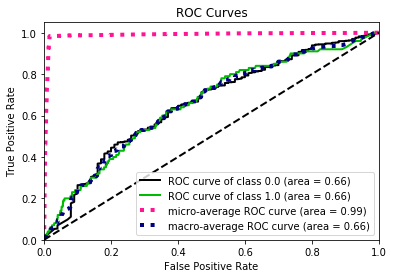

In [15]:
import scikitplot as skplt
import matplotlib.pyplot as plt
y_true = y_val
y_probas = gs.predict_proba(X_val)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [8]:
# from sklearn.metrics import roc_auc_score
# import xgboost
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from sklearn.externals import joblib
# from sklearn.model_selection import train_test_split
# import numpy as np
# import pandas as pd

# def objective(param_space):
#     xgbst = xgboost.XGBClassifier(n_estimators = 2,
#                             learning_rate=param_space['learning_rate'],
#                             colsample_bytree=param_space['colsample_bytree'],
#                             max_depth = param_space['max_depth'],
#                             subsample = param_space['subsample'],
#                             n_jobs=-1,
#                             missing=-1.0)

#     eval_set  = [(X_train, y_train), (X_test, y_test)]

#     xgbst.fit(X_train, y_train,
#             eval_set=eval_set, eval_metric="auc",
#             early_stopping_rounds=5)

#     pred = xgbst.predict_proba(X_test)[:,1]
#     auc = roc_auc_score(y_test, pred)
#     print("SCORE:", auc)

#     return{'loss':1-auc, 'status': STATUS_OK }


# param_space ={
#         'n_estimators': hp.choice('n_estimators', np.arange(10, 110, 10, dtype=int)),
#         'learning_rate': hp.uniform('learning_rate', 0.1,0.6),
#         'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
#         'max_depth': hp.choice('max_depth', np.arange(5, 15, dtype=int)),
#         'subsample': hp.uniform('subsample', 0.7, 1)
#     }


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# trials = Trials()
# best = fmin(fn=objective,
#             space=param_space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials)